In [7]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torcheval.metrics import MulticlassAccuracy

In [8]:
# gettign the data
from numpy import rot90


train_data = datasets.FashionMNIST(
    root= "data",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_data = datasets.FashionMNIST(
    root= "data",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)


In [9]:
device = "cuda"

In [10]:
class_names = train_data.classes

In [11]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [12]:
image, label = train_data[0]

Text(0.5, 1.0, 'Ankle boot')

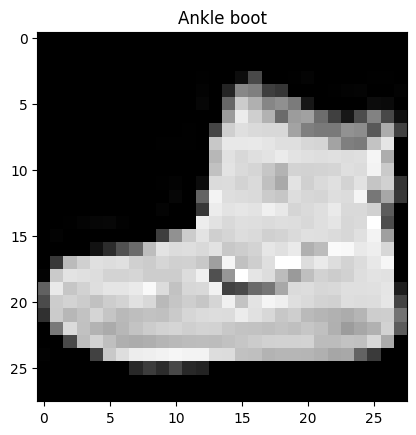

In [13]:
plt.imshow(image.squeeze(), cmap="gray" )
plt.title(class_names[label])

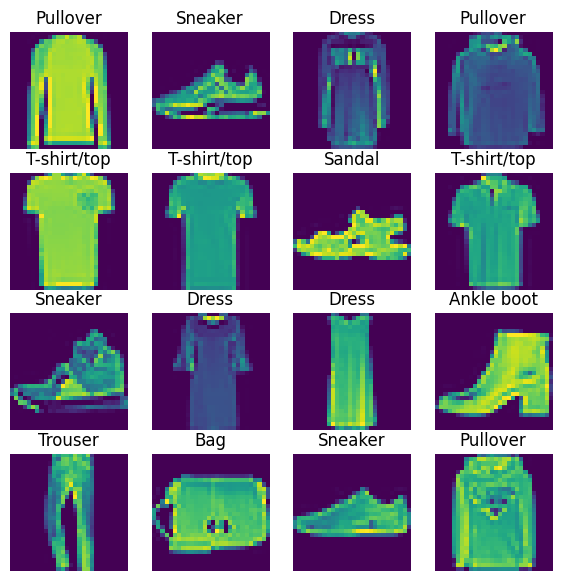

In [14]:
rows, cols = 4,4
fig = plt.figure(figsize=(7,7))
for i in range(1, rows*cols +1):
    random = int(torch.randint(1, len(train_data), size=[1]).item())
    img, la = train_data[random]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze())
    plt.title(class_names[la])
    plt.axis(False)

In [15]:
class ImageClassifier(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            nn.Conv2d(1,32,(3,3), padding=1), # 28*28
            # nn.MaxPool2d(2,1), # 27 x 27
            nn.Tanh(),
            # nn.Conv2d(16,32,3), # 26x26
            # # nn.MaxPool2d(2,1), #24x24
            # nn.ReLU(),
            nn.Conv2d(32,64,(3,3)), # 24 x 24
            # nn.MaxPool2d(2,1), # 21 x 21
            nn.Tanh(),
            nn.Conv2d(64,64,(3,3)), # 22 x 22
            # nn.MaxPool2d(2,1), # 21 x 21
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*(24)*(24),10),
            # nn.ReLU(),
            # nn.Linear(5,10),
            # nn.Softmax()
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
model = ImageClassifier().to(device)

In [17]:
model

ImageClassifier(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=36864, out_features=10, bias=True)
  )
)

In [18]:
train_data_ldr = DataLoader(train_data, batch_size=32, shuffle=True)
test_data_ldr = DataLoader(train_data, batch_size=32, shuffle=True)

In [19]:
for img, label in train_data_ldr:
    with torch.inference_mode():
        preds = model(img.to(device))
    break

In [20]:
preds

tensor([[ 0.0248, -0.0652, -0.0098, -0.0212,  0.0426, -0.0060, -0.0459, -0.0158,
          0.0460, -0.0537],
        [ 0.0291, -0.0807, -0.0366, -0.0280,  0.0188,  0.0249, -0.0452, -0.0056,
          0.0468, -0.0393],
        [-0.0094, -0.1047, -0.0352, -0.0522,  0.0278,  0.0325, -0.0256, -0.0057,
          0.0482, -0.0757],
        [ 0.0400, -0.0847, -0.0446, -0.0273,  0.0265,  0.0325, -0.0461, -0.0005,
          0.0548, -0.0228],
        [ 0.0237, -0.0754, -0.0215, -0.0293,  0.0341, -0.0050, -0.0339, -0.0115,
          0.0592, -0.0529],
        [ 0.0252, -0.1180, -0.0407, -0.0637,  0.0504,  0.0467, -0.0675,  0.0122,
          0.0652, -0.0338],
        [ 0.0183, -0.0953, -0.0113, -0.0417,  0.0411,  0.0114, -0.0199, -0.0112,
          0.0728, -0.0682],
        [ 0.0098, -0.1240, -0.0040, -0.0602,  0.0395,  0.0621, -0.0358,  0.0218,
          0.0673, -0.0580],
        [ 0.0172, -0.0896, -0.0214, -0.0499,  0.0522,  0.0495, -0.0284,  0.0064,
          0.0542, -0.0516],
        [ 0.0201, -

In [21]:
with torch.inference_mode():
    preds = model(img.to(device))

preds.shape

torch.Size([32, 10])

In [22]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()
epochs = 10
accuracy_fn = MulticlassAccuracy()
total_train_length = len(train_data_ldr)
total_test_length = len(test_data_ldr)


In [23]:
import time

In [24]:
for epoch in range(epochs):
    total_train_acc = 0
    total_test_acc = 0
    start = time.time()
    train_loss = 0
    test_loss_total = 0
    for batch in train_data_ldr:
        img, label = batch
        img,label = img.to(device), label.to(device).long()
        model.train()
        y_logits= model(img)
        # print(y_logits)
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
        # print(y_preds)

        loss = loss_fn(y_logits, label)
        train_loss += loss

        acc = accuracy_fn.update(y_preds, label).compute()

        total_train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for batch in test_data_ldr:
        test_img, test_label = batch
        test_img,  test_label = test_img.to(device), test_label.to(device).long()
        model.eval()
        with torch.inference_mode():
            test_y_logits= model(test_img)
            test_y_preds = torch.softmax(test_y_logits, dim=1).argmax(dim=1)
            test_loss = loss_fn(test_y_logits, test_label)
            test_loss_total += test_loss
            test_acc = accuracy_fn.update(test_y_preds, test_label).compute()

            total_test_acc += test_acc
    end = time.time()
    print(f"Took: {end-start} for epoch : {epoch+1}: ")
    print(f"Train Loss is: {train_loss / total_train_length} \t| Test Loss is: {test_loss_total/ total_test_length}")
    print(f"Train Accuracy is: {total_train_acc/total_train_length} \t\t | Test Accuracy : {total_test_acc/total_test_length}")
    print("-"*40)
    print()

Took: 21.884207010269165 for epoch : 1: 
Train Loss is: 0.40108588337898254 	| Test Loss is: 0.26769158244132996
Train Accuracy is: 0.8132926821708679 		 | Test Accuracy : 0.8720986843109131
----------------------------------------

Took: 21.820255756378174 for epoch : 2: 
Train Loss is: 0.27290114760398865 	| Test Loss is: 0.21239225566387177
Train Accuracy is: 0.8850717544555664 		 | Test Accuracy : 0.8930614590644836
----------------------------------------

Took: 22.21857762336731 for epoch : 3: 
Train Loss is: 0.21956351399421692 	| Test Loss is: 0.16704750061035156
Train Accuracy is: 0.8995782136917114 		 | Test Accuracy : 0.9049437046051025
----------------------------------------

Took: 21.933188915252686 for epoch : 4: 
Train Loss is: 0.17788589000701904 	| Test Loss is: 0.13513264060020447
Train Accuracy is: 0.910184919834137 		 | Test Accuracy : 0.9144759178161621
----------------------------------------

Took: 22.07924509048462 for epoch : 5: 
Train Loss is: 0.1483478099107

Predicited Class : T-shirt/top 
Actual Class: T-shirt/top


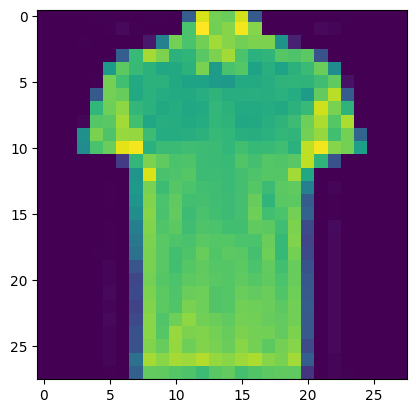

In [34]:
random = int(torch.randint(1, len(train_data), size=[1]).item())
img, label = train_data[random]
image = torch.unsqueeze(img, 1)
# print(image.shape)
plt.imshow(img.squeeze())
logit = model(image.to(device))
pred = torch.softmax(logit,1).argmax().item()
print(f"Predicited Class : {class_names[pred]} \nActual Class: {class_names[label]}")

In [35]:
torch.save(model, "mutliclass.h")